## Purpose of this notebook: 

We study chess games.

A game confronts two players (white vs black). It has a limited number of turns $T$. Here, the players are algorithms, playing a move per turn. The current turn is denoted $t$, $ 1 \le t \le T$.

### Idea :

The algorithms have different perceptions of the issue of the game. They give scores to their positions, given their material and the case controlled by their pieces, and their positions on the board.

Somehow, the different algorithms involved in these games do not always weight/estimate the score the same way.

In numerous games, there are significant differences of scores that can last several turns, from 5 to 20 turns. We want to highlight and isolate these games.

The purpose of this notebook is to define a metric to keep the "interesting" situations, ie. when the estimations of the algorithms differ during a significant number of turns.


### Data :

To study these games, we've got $w$, the estimated scores of the white player and $b$, the estimated score of the black player.

We denote $w(t)$ (resp. $b(t)$) the estimated score of the white player (resp. the black player) on turn $t$.

For instance, let's define the ideal case, where the estimated scores of white are just the opposites of the black's.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

def plot_game(w, b):
    # w -> white scores
    # b -> black scores
    long = min(len(w), len(b))
    plt.plot(range(long), w[:long], 'o-', c="white", label="white")
    plt.plot(range(long), b[:long], 'o-', c="black", label="black")
    plt.ylabel("Scores")
    plt.xlabel("Turns")
    plt.xticks([k*5 for k in range(int(long/5+1))])
    plt.legend()
    plt.show()

nb_turns = 20

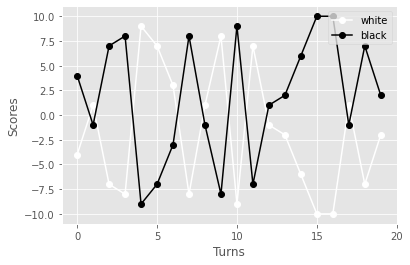

In [2]:
w = np.random.randint(-10, 10, nb_turns)
b = -w

plot_game(w, b)

### Constraints & problems :

Based on the observations of the curves (see the SwingAnalysisLeelaSF notebook)

**Pb1** : The absolute score values often increase when the game is about to end, (probably because of the clear advantage of a side compared to the other one).

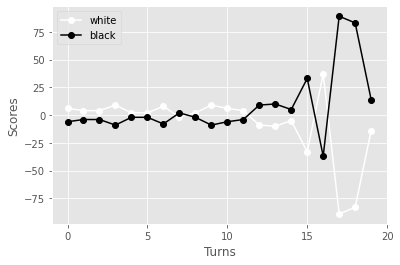

In [3]:
pb1_w = np.concatenate((np.random.randint(-10, 10, int(3*nb_turns/4)), 
                        np.random.randint(-100, 100, int(nb_turns/4))))
pb1_b = -pb1_w

plot_game(pb1_w, pb1_b)


> *Possible solutions* $\rightarrow$ filter the values that are too big (greater than a threshold e.g. $\ge 10$) or  study the ratio $\frac{w(t)}{b(t)}$

**Pb2** : If the curves are not exact opposites, but symetrical / a constant line, maybe we don't want to keep the game?

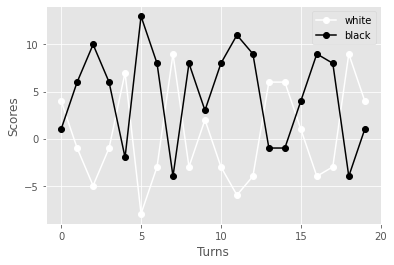

In [4]:
delta = 5

pb2_w = np.random.randint(-10, 10, nb_turns)
pb2_b = -pb2_w + delta

plot_game(pb2_w, pb2_b)

> *Possible solutions* $\rightarrow$ study variations

**Pb3** : Sometimes, the differences of estimation just lasts few turns. We have to be more precise to detect the local changes, and adapt the different metrics.

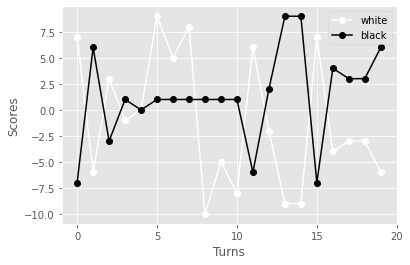

In [5]:
pb3_w = np.random.randint(-10, 10, nb_turns)
pb3_b = [-pb3_w[k] if k < 5 or k > 10 else 1.0 for k in range(len(pb3_w))]

plot_game(pb3_w, pb3_b)

> *Possible solutions* $\rightarrow$ shifting windows

### Proposed metrics :

- A simple metric is the sum of absolute differences of scores, i.e.

$m1 = \frac{1}{T}*\sum_{t \in [1,T]}||w(t)|-|b(t)||$

In [28]:
def m1(w, b):
    long = min(len(w), len(b))
    return np.mean(np.abs(np.abs(w[:long])-np.abs(b[:long])))

In [29]:
m1(w,b)

0.0

In [30]:
m1(pb1_w, pb1_b)

0.0

In [31]:
m1(pb2_w, pb2_b)

4.5

In [32]:
m1(pb3_w, pb3_b)

1.95

<font color="green">If the estimated scores have opposite values, m1 should stick to 0</font>

<font color="orange">We assume that the estimated scores have different signs, raise an error if the values have the same sign?</font>

<font color="red">Pb1 is not solved (if the values slightly change)</font>

<font color="red">Pb2 is not solved, the difference is caught</font>

<font color="green">Can be adapted to Pb3</font>

- Another possible metric, the log of the opposite of the ratio $\frac{white}{black}$, i.e.

$m2 = \frac{1}{T}*\sum_{t \in [1,T]} |log(-\frac{w(t)}{b(t)})|$

In [11]:
def m2(w, b):
    long = min(len(w), len(b))
    res = np.abs(np.log(np.abs(np.divide(w[:long],b[:long]))))
    # supress nan, div by 0
    res = res[~np.isnan(res)]
    # supress inf, div by low values
    res = res[np.abs(res) < 1e100]
    return np.mean(res)

In [12]:
m2(w,b)

0.0

In [13]:
m2(pb1_w, pb1_b)

0.0

In [14]:
m2(pb2_w, pb2_b)

1.0967988856849802

In [15]:
m2(pb3_w, pb3_b)

0.6251351883451651


<font color="green">m2 should stick to 0 if $w(t) \sim - b(t) \forall t \in [1,T]$ </font>

<font color="green">Pb1 is solved</font>

<font color="red">Pb2 is not solved</font>

<font color="green">Can be adapted to Pb3</font>

<font color="red"> Exception with low values of scores (for draws) </font>

- A third metric, inspired by the ratio of white and black progressions, i.e.

$m3 = \frac{1}{T}*\sum_{t \in [2,T]} |max(\frac{1+|w(t)-w(t-1)|}{1+|b(t)-b(t-1)|}, \frac{1+|b(t)-b(t-1)|}{1+|w(t)-w(t-1)|})-1|$


A variant is possible with a delta of $t_{0}$, interesting for Pb3

$m3_v(t_{0}) = \frac{1}{T}*\sum_{t \in [t_{0}+1,T]} |max(\frac{1+|w(t)-w(t-t_{0})|}{1+|b(t)-b(t-t_{0})|}, \frac{1+|b(t)-b(t-t_{0})|}{1+|w(t)-w(t-t_{0})|})-1|$

With these notations, $m3 = m3_v(t_{0}) $

In [16]:
def m3v(w, b, t0):
    long = min(len(w), len(b))
    diff_w = [1+np.abs(w[i]-w[i-t0]) for i in range(t0,long)]
    diff_b = [1+np.abs(b[i]-b[i-t0]) for i in range(t0,long)]
    res = [max(diff_w[i]/diff_b[i], diff_b[i]/diff_w[i])-1 for i in range(len(diff_w))]
    return np.mean(res)

In [17]:
m3v(w,b,1)

0.0

In [18]:
m3v(pb1_w, pb1_b, 1)

0.0

In [19]:
m3v(pb2_w, pb2_b, 1)

0.0

In [20]:
m3v(pb3_w, pb3_b, 1)

1.993421052631579

In [21]:
m3v(pb3_w, pb3_b, 6)

1.571031746031746

<font color="green">m3 should stick to 0 if $w(t) \sim - b(t)   \forall t \in [1,T]$</font>

<font color="red">Pb1 is not solved (if the values slightly change, it is sensible to scale)</font>

<font color="green">Pb2 is solved</font>

<font color="green">Can be adapted to Pb3</font>

<font color="red">Do not catch a persistent difference that lasts 20 turns (just counted once)</font>

## Evaluation on real games

In [22]:
%matplotlib inline

import chess.pgn

plt.style.use('ggplot')
pgnfile="TCEC_Season_20_-_Superfinal.pgn" # archive.pgn" 

## basically analysis of PGN 
def nb_moves(g):
    nbmove = 0
    for move in g.mainline_moves():
        if (move is not None):
            nbmove = nbmove + 1
    return nbmove / 2

pgn = open(pgnfile)
df = pd.DataFrame(columns=['nbmoves', "AZresult", "AZwhite"])
idg = 0
while True:
    game = chess.pgn.read_game(pgn)
    if game is None:
        break
    whiteplayer = game.headers.get("White") == 'AlphaZero'
    result = "WIN" if (whiteplayer and game.headers.get('Result') == '1-0') else ("LOSE" if (whiteplayer and game.headers.get('Result') == '0-1') else "DRAW")
    df.loc[idg] = (int(nb_moves(game)), result, whiteplayer)
    idg = idg + 1
    
#df['AZresult'].value_counts()
#plt.figure()
#plt.boxplot(pd.to_numeric(df['nbmoves']))
#plt.title("number of moves")
# df.boxplot(column=['nbmoves'])
#plt.show()

#df.boxplot(pd.to_numeric(df['nbmoves']))
#df[df['AZresult'] == 'WIN']
#df
#df.sort_values(by="nbmoves")

Evol_score = 0.07
M1_score =  0.011875000000000002
M2_score =  nan
M3_score =  0.006170212765957452


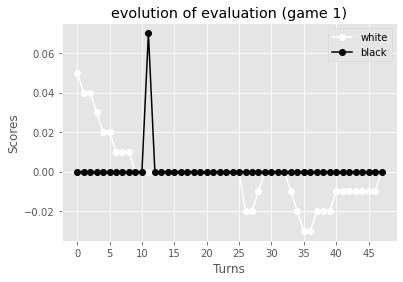

Evol_score = 0.06
M1_score =  0.019375
M2_score =  nan
M3_score =  0.0064516129032258125


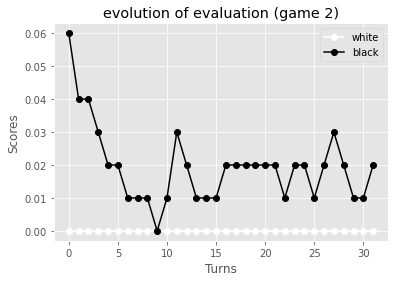

Evol_score = 0.59
M1_score =  0.33686567164179104
M2_score =  0.9134253945196625
M3_score =  0.030648360593660537


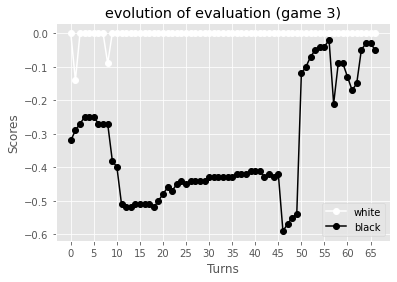

Evol_score = 0.19
M1_score =  0.09192307692307691
M2_score =  0.6105424014291504
M3_score =  0.06442165272268963


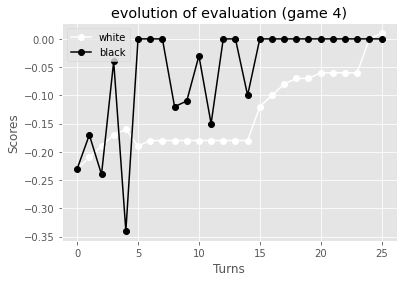

Evol_score = 2.960000000000001
M1_score =  0.5852631578947369
M2_score =  0.32510962100646545
M3_score =  0.20280354975879353


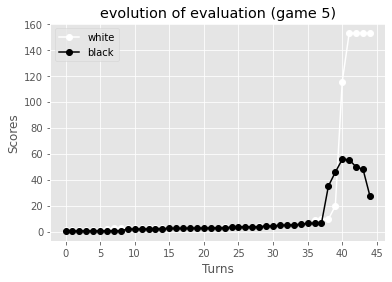

Evol_score = 2.8999999999999995
M1_score =  1.0880555555555556
M2_score =  0.5699304876820288
M3_score =  0.33044869365630153


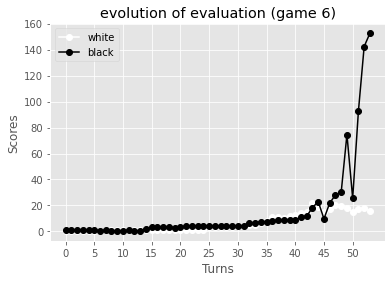

Evol_score = 0.26
M1_score =  0.039558823529411764
M2_score =  0.5723987783724848
M3_score =  0.015853646320357608


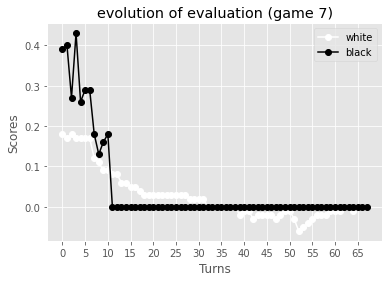

Evol_score = 0.2
M1_score =  0.07170731707317073
M2_score =  0.4093121964145059
M3_score =  0.029173979790897447


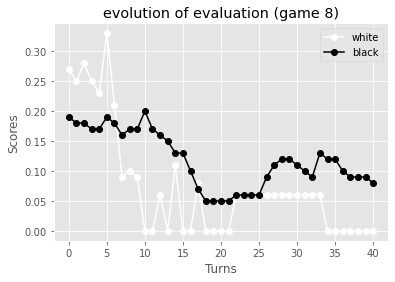

Evol_score = 0.67
M1_score =  0.14176470588235296
M2_score =  1.236588581801579
M3_score =  0.06430707122520923


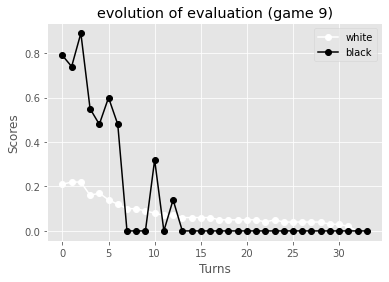

Evol_score = 0.32
M1_score =  0.13745454545454544
M2_score =  0.34213969905937086
M3_score =  0.03459198229248065


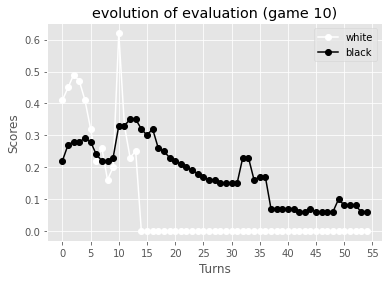

Evol_score = 0.2
M1_score =  0.03870967741935485
M2_score =  1.1197547251652977
M3_score =  0.019306930693069317


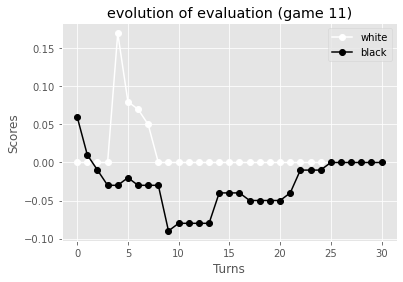

Evol_score = 0.51
M1_score =  0.2721599999999999
M2_score =  1.0055154948615532
M3_score =  0.02740378336599191


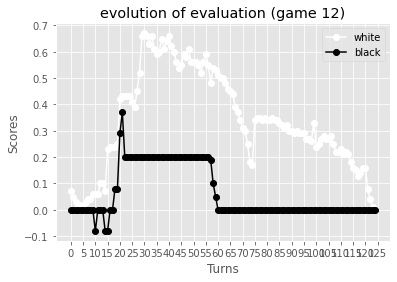

Evol_score = 0.39
M1_score =  0.027586206896551727
M2_score =  0.46025996404665354
M3_score =  0.019249915042302283


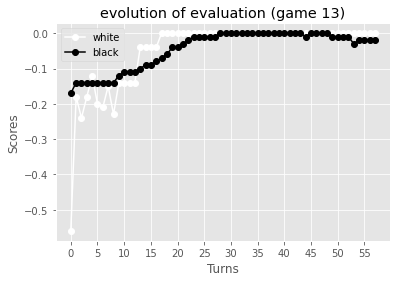

Evol_score = 0.42
M1_score =  0.06627450980392156
M2_score =  0.5790307824904793
M3_score =  0.02377048928193792


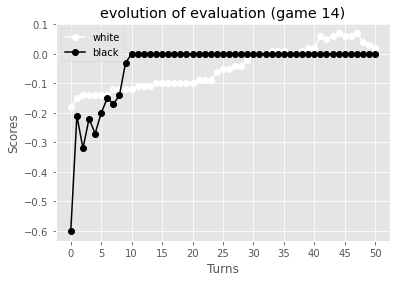

Evol_score = 0.12
M1_score =  0.05588235294117647
M2_score =  0.3758761001898778
M3_score =  0.01329456475059272


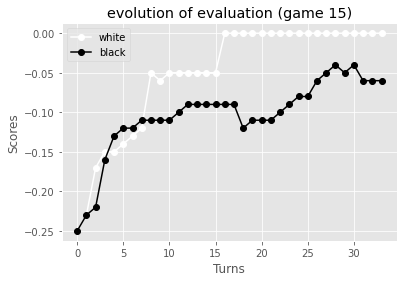

Evol_score = 1.01
M1_score =  0.29238095238095246
M2_score =  1.7876684820405473
M3_score =  0.04022502494066128


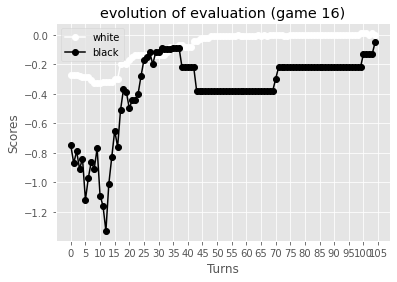

Evol_score = 0.5399999999999999
M1_score =  0.13725
M2_score =  0.5460579117814228
M3_score =  0.05701944130185982


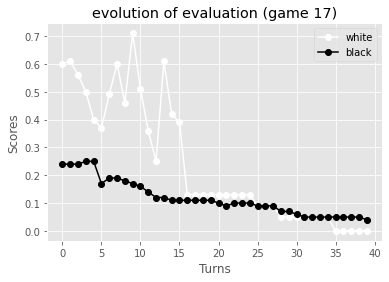

Evol_score = 0.28
M1_score =  0.09829268292682927
M2_score =  0.5371051472732759
M3_score =  0.03003791708572926


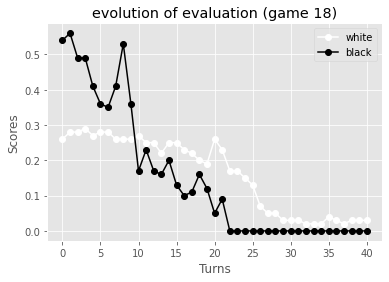

Evol_score = 0.71
M1_score =  0.17421052631578948
M2_score =  0.9684757567093559
M3_score =  0.06260478385034121


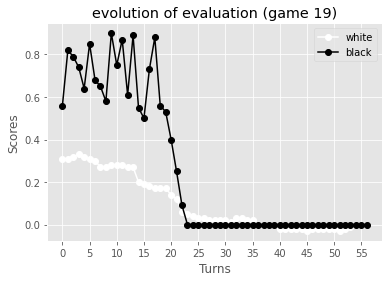

Evol_score = 0.32
M1_score =  0.0988888888888889
M2_score =  0.5568496427458601
M3_score =  0.022920885046421764


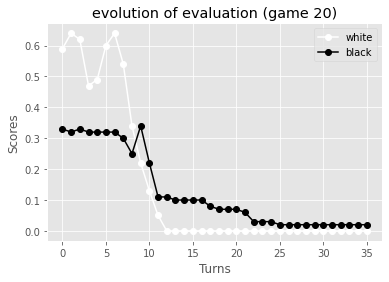

Evol_score = 0.23
M1_score =  0.10212765957446808
M2_score =  1.1730738548346262
M3_score =  0.01992479299080805


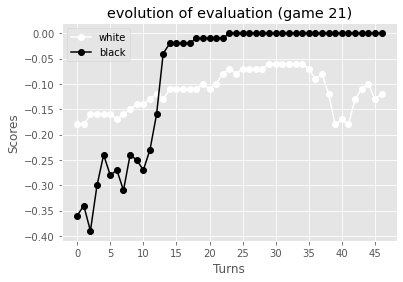

Evol_score = 0.42
M1_score =  0.07375000000000001
M2_score =  1.2122981672982545
M3_score =  0.04077548569838691


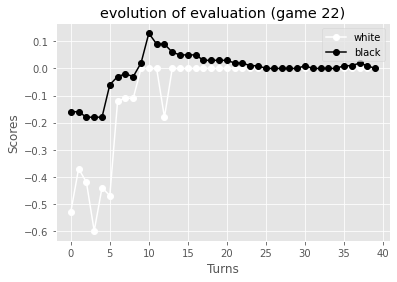

Evol_score = 0.5800000000000001
M1_score =  0.13333333333333333
M2_score =  0.6458097402237892
M3_score =  0.08432815915862685


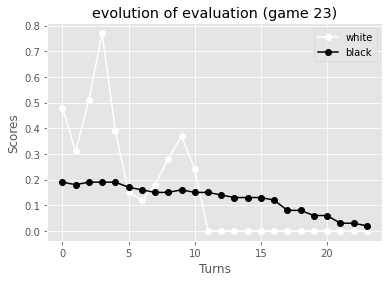

Evol_score = 0.24000000000000002
M1_score =  0.11227272727272726
M2_score =  0.4824644202871268
M3_score =  0.06320274130814675


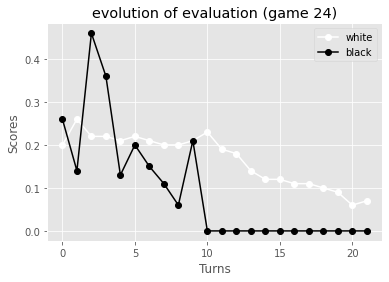

Evol_score = 0.54
M1_score =  0.14328124999999997
M2_score =  1.7698156550406399
M3_score =  0.02497564042118498


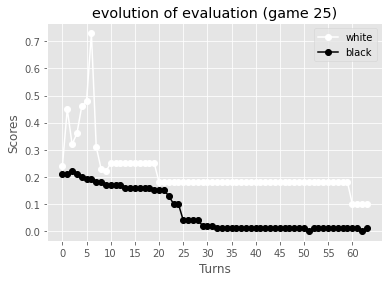

Evol_score = 0.13
M1_score =  0.08499999999999999
M2_score =  0.23659726208584894
M3_score =  0.018621249687994012


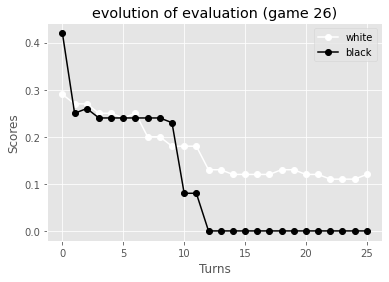

Evol_score = 0.49
M1_score =  0.2022857142857143
M2_score =  1.1193770353379862
M3_score =  0.03482109344068415


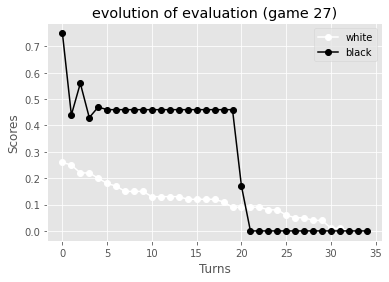

Evol_score = 0.45
M1_score =  0.147972972972973
M2_score =  0.5948522202394652
M3_score =  0.03594775752020551


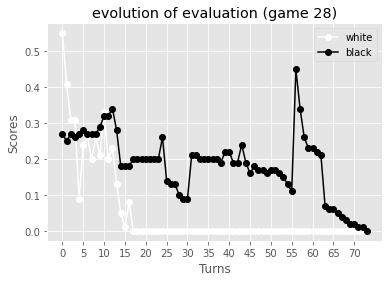

Evol_score = 0.36
M1_score =  0.06700000000000002
M2_score =  0.702244197164699
M3_score =  0.021915187924256133


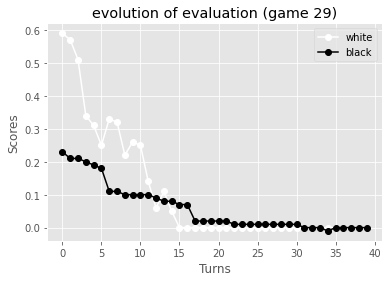

Evol_score = 0.41999999999999993
M1_score =  0.20512820512820515
M2_score =  0.658010963669433
M3_score =  0.03787192446406593


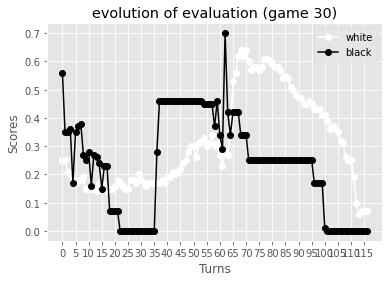

Evol_score = 0.49000000000000005
M1_score =  0.2592857142857143
M2_score =  0.9335600387351314
M3_score =  0.04885078129302553


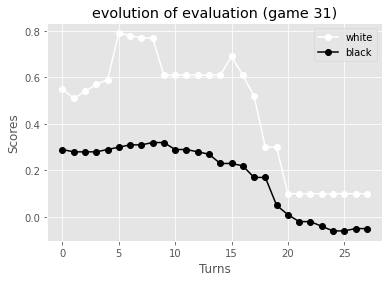

Evol_score = 0.45
M1_score =  0.08857142857142856
M2_score =  0.6474323186862776
M3_score =  0.03850556000976688


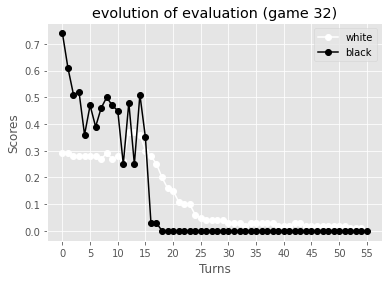

Evol_score = 4.550000000000001
M1_score =  1.230625
M2_score =  1.0440405143743003
M3_score =  0.13448130816111575


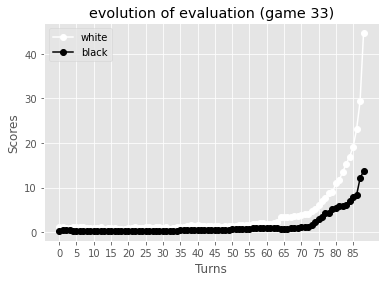

Evol_score = 0.6
M1_score =  0.2471764705882353
M2_score =  0.5289136069729234
M3_score =  0.055224392950319966


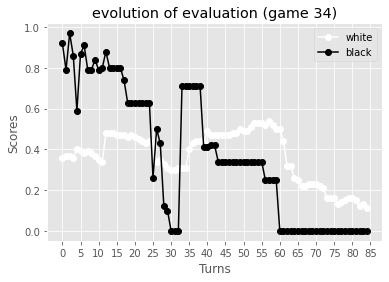

Evol_score = 0.49999999999999994
M1_score =  0.0842
M2_score =  0.6932889757372714
M3_score =  0.04699368741055973


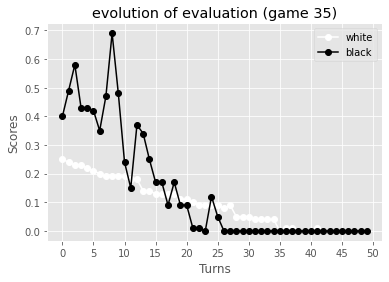

Evol_score = 0.29000000000000004
M1_score =  0.12466666666666666
M2_score =  0.5437394584603004
M3_score =  0.024859228126554875


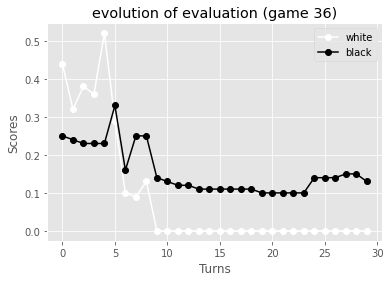

Evol_score = 0.98
M1_score =  0.6040140845070422
M2_score =  1.8187957396949792
M3_score =  0.020331740307948196


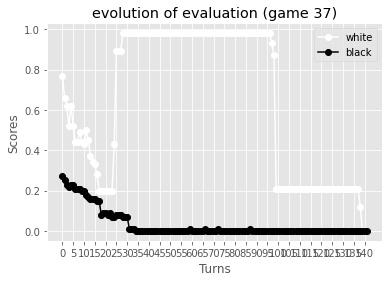

Evol_score = 0.64
M1_score =  0.14135135135135135
M2_score =  0.492856431780598
M3_score =  0.058079089283127376


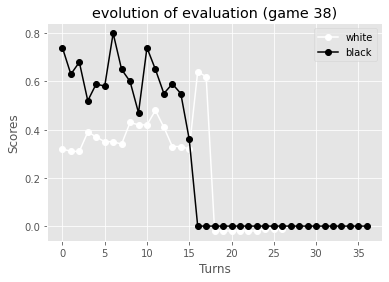

Evol_score = 0.5
M1_score =  0.08
M2_score =  0.6197674160119379
M3_score =  0.041262735810419046


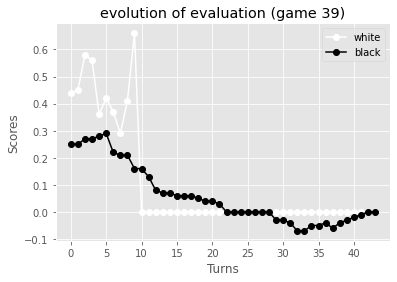

Evol_score = 0.32
M1_score =  0.11160714285714288
M2_score =  0.7065288095108572
M3_score =  0.02931275096771861


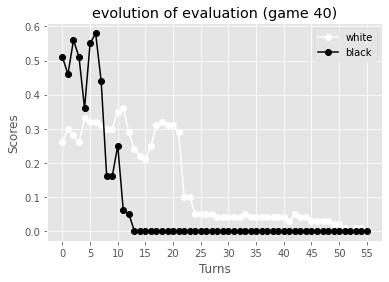

Evol_score = 0.44
M1_score =  0.14600000000000002
M2_score =  0.5915399241247231
M3_score =  0.05745307447212279


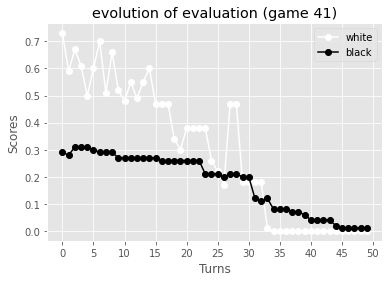

Evol_score = 0.21999999999999997
M1_score =  0.12057142857142857
M2_score =  0.46331716666897477
M3_score =  0.03448907693537521


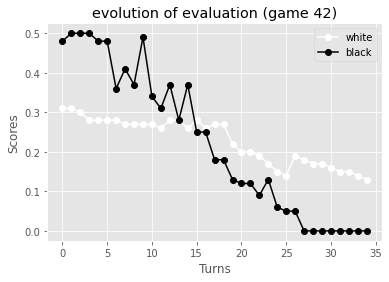

Evol_score = 0.96
M1_score =  0.3767567567567567
M2_score =  1.1062963257122045
M3_score =  0.099704228418273


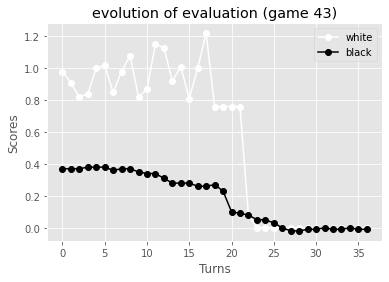

Evol_score = 0.4
M1_score =  0.14702127659574468
M2_score =  0.493457459565895
M3_score =  0.03988306670907451


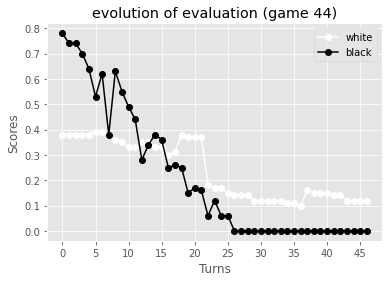

Evol_score = 0.65
M1_score =  0.366551724137931
M2_score =  0.7653507702944123
M3_score =  0.11471623265758601


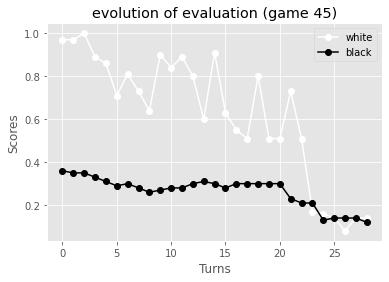

Evol_score = 0.55
M1_score =  0.20643835616438355
M2_score =  0.5636287000043677
M3_score =  0.05504464624920376


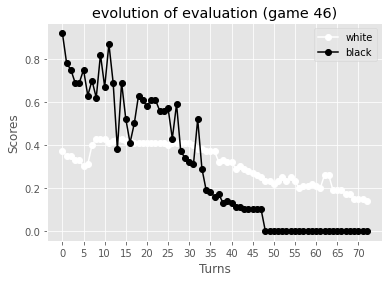

Evol_score = 0.65
M1_score =  0.17288135593220338
M2_score =  0.6344542389789642
M3_score =  0.04866207490596832


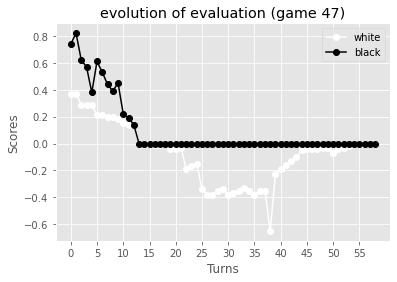

Evol_score = 0.35
M1_score =  0.11095238095238097
M2_score =  0.3889519929766908
M3_score =  0.0353614040596038


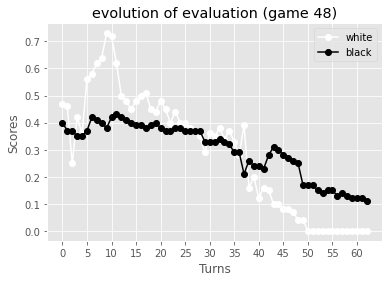

Evol_score = 2.01
M1_score =  0.4405813953488372
M2_score =  0.9111662069598405
M3_score =  0.11791127292200163


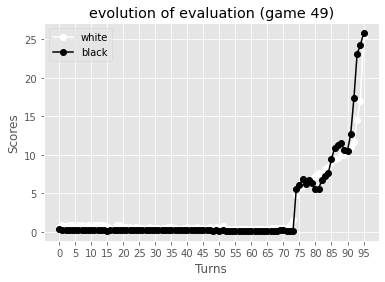

Evol_score = 0.44000000000000006
M1_score =  0.13083969465648856
M2_score =  0.16607854163359856
M3_score =  0.06079093681188761


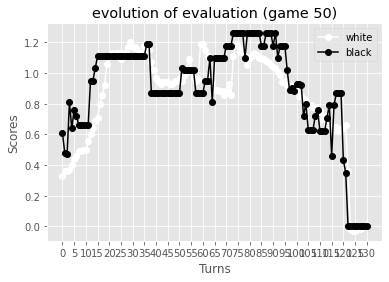

Evol_score = 0.7999999999999999
M1_score =  0.3333333333333333
M2_score =  0.7025319873612631
M3_score =  0.08652804598286166


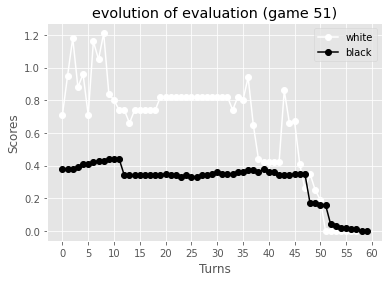

Evol_score = 5.119999999999999
M1_score =  1.626046511627907
M2_score =  0.6135200578107675
M3_score =  0.27140531734100276


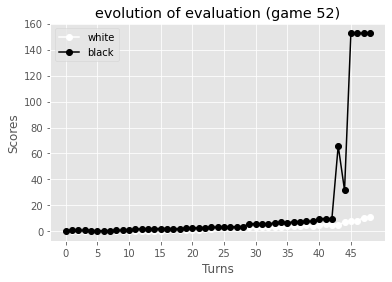

Evol_score = 0.28
M1_score =  0.1552238805970149
M2_score =  1.4684710237268692
M3_score =  0.021159531919578523


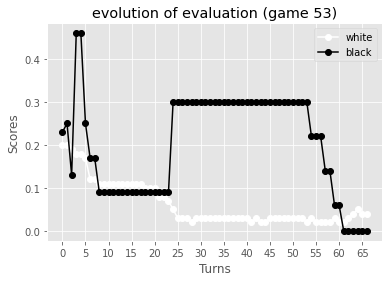

Evol_score = 0.24
M1_score =  0.086
M2_score =  0.4746546311403955
M3_score =  0.025826281590096728


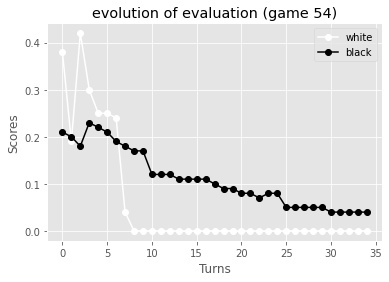

Evol_score = 1.09
M1_score =  0.40000000000000013
M2_score =  2.341232235961352
M3_score =  0.04350422339820462


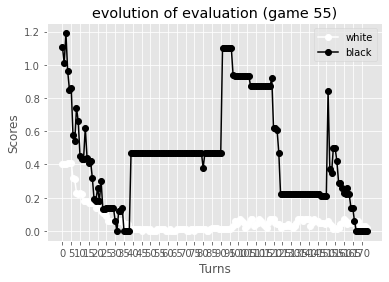

Evol_score = 2.6099999999999994
M1_score =  0.5160416666666666
M2_score =  0.31936543412029084
M3_score =  0.17967265054957232


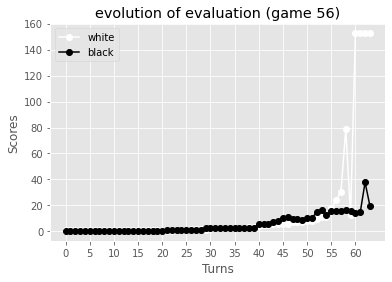

Evol_score = 0.24999999999999994
M1_score =  0.0656
M2_score =  0.3986606342428525
M3_score =  0.028013431455608768


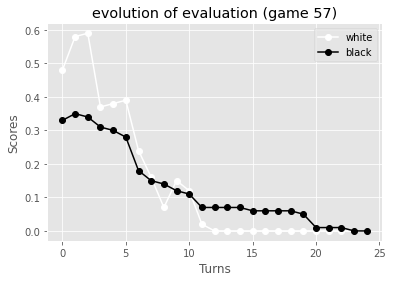

Evol_score = 0.25000000000000006
M1_score =  0.07826923076923076
M2_score =  0.48088388097316376
M3_score =  0.021175765758407124


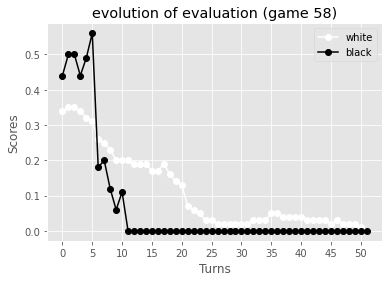

Evol_score = 7.57
M1_score =  2.561944444444445
M2_score =  1.2259253988129162
M3_score =  0.2676125781354166


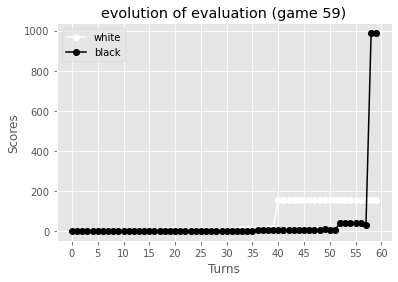

Evol_score = 0.77
M1_score =  0.20942028985507244
M2_score =  0.4748056898140126
M3_score =  0.07297567530832659


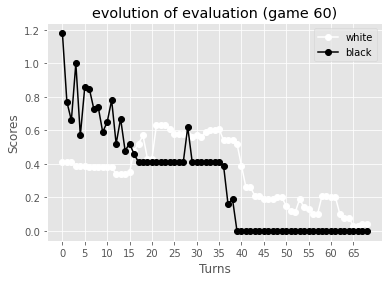

Evol_score = 2.17
M1_score =  1.3246835443037974
M2_score =  2.2659144338704804
M3_score =  0.08333096113154453


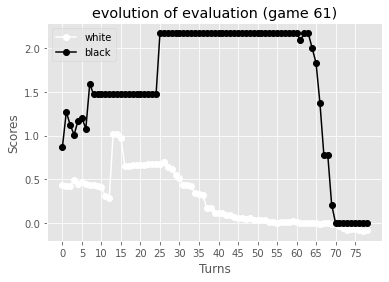

Evol_score = 1.6599999999999997
M1_score =  0.6858536585365853
M2_score =  0.4130485649277305
M3_score =  0.16823861598775203


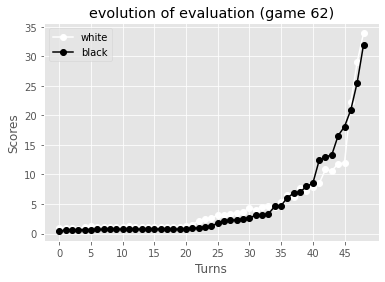

Evol_score = 0.7899999999999999
M1_score =  0.1636923076923077
M2_score =  0.7027795865973079
M3_score =  0.062243499213000125


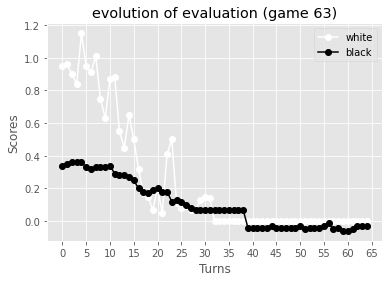

Evol_score = 0.67
M1_score =  0.2966336633663366
M2_score =  0.6411123639008848
M3_score =  0.03300479894289239


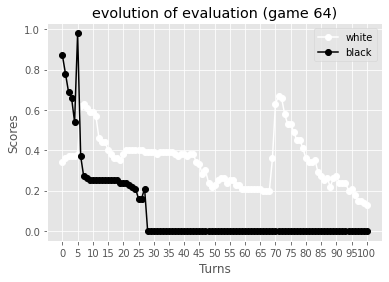

Evol_score = 5.989999999999999
M1_score =  1.2693333333333332
M2_score =  0.9835263172790821
M3_score =  0.23835361247651599


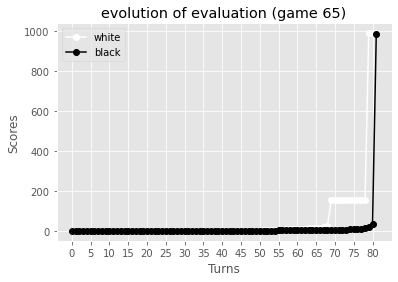

Evol_score = 3.920000000000001
M1_score =  0.8699999999999999
M2_score =  0.3810362721664166
M3_score =  0.2471057018054017


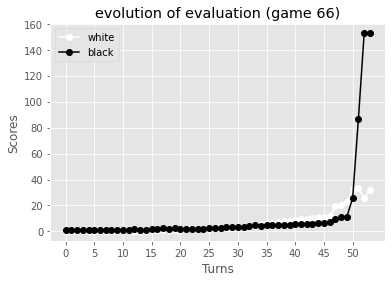

Evol_score = 0.6799999999999999
M1_score =  0.30526315789473685
M2_score =  0.6909421675901706
M3_score =  0.08401666827895687


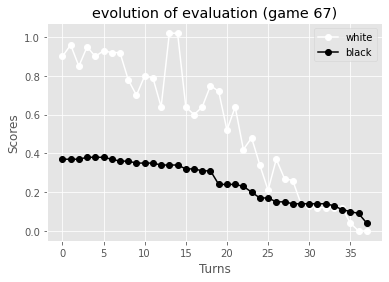

Evol_score = 0.61
M1_score =  0.2569565217391304
M2_score =  0.9204688769513889
M3_score =  0.05245238452756645


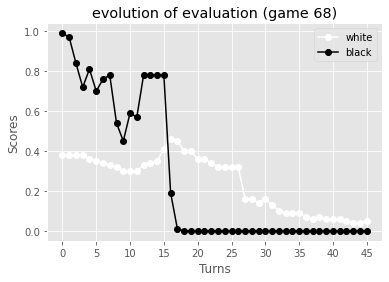

Evol_score = 0.6100000000000001
M1_score =  0.15793103448275864
M2_score =  0.5975530268025391
M3_score =  0.06262317237748825


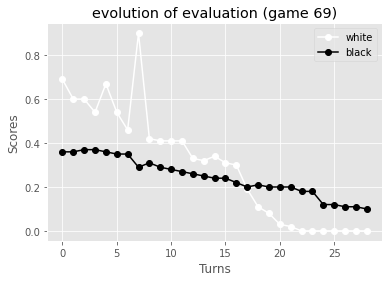

Evol_score = 0.41
M1_score =  0.1185714285714286
M2_score =  0.6487472409336346
M3_score =  0.03859874666711954


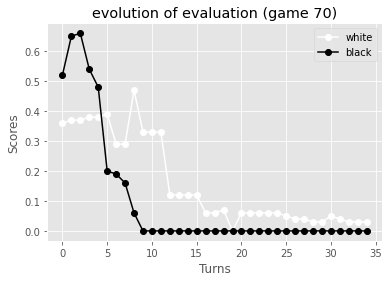

Evol_score = 3.1599999999999993
M1_score =  1.39
M2_score =  0.8521116821933338
M3_score =  0.17832568448016364


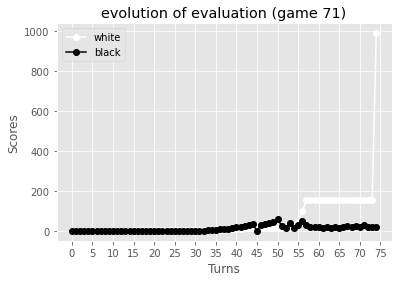

Evol_score = 0.71
M1_score =  0.23249999999999998
M2_score =  0.5012189871686982
M3_score =  0.0806129968452422


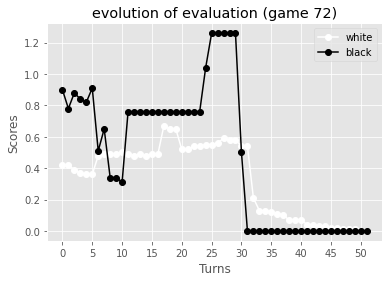

Evol_score = 0.61
M1_score =  0.17750000000000002
M2_score =  1.2888449985257386
M3_score =  0.036925668122242405


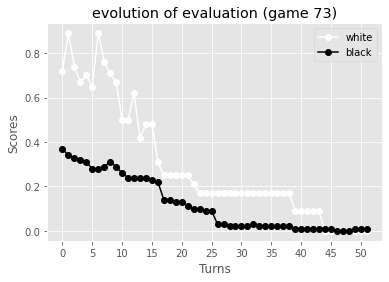

Evol_score = 0.44000000000000006
M1_score =  0.12075
M2_score =  0.36689408934725287
M3_score =  0.060187775080029


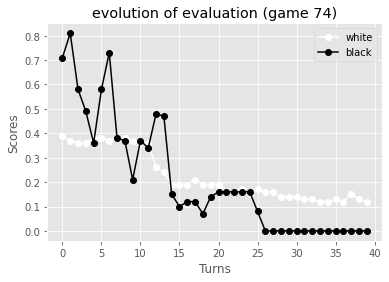

Evol_score = 2.47
M1_score =  1.3363414634146342
M2_score =  3.4442724104103064
M3_score =  0.06299465204215716


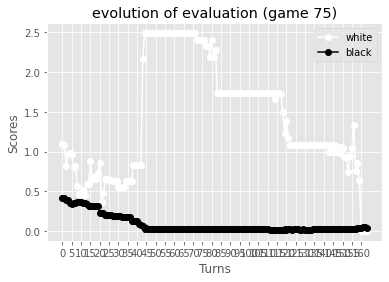

Evol_score = 0.45000000000000007
M1_score =  0.13464285714285715
M2_score =  0.38018286916584054
M3_score =  0.027103557408390294


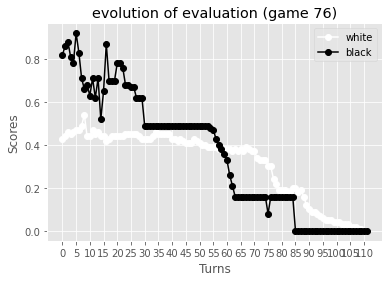

Evol_score = 4.33
M1_score =  1.9401923076923078
M2_score =  1.074357711938814
M3_score =  0.14225160171848622


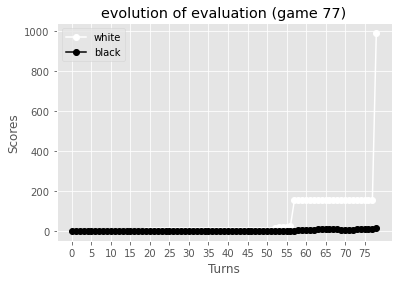

Evol_score = 0.30000000000000004
M1_score =  0.15653846153846152
M2_score =  0.36186751795190436
M3_score =  0.055380894353171596


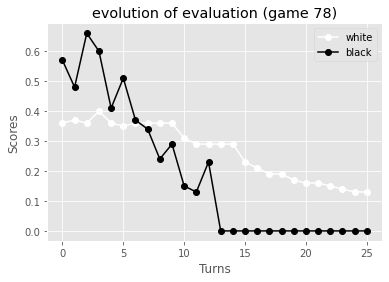

Evol_score = 5.1
M1_score =  1.52
M2_score =  0.8961606670871007
M3_score =  0.2056379268052527


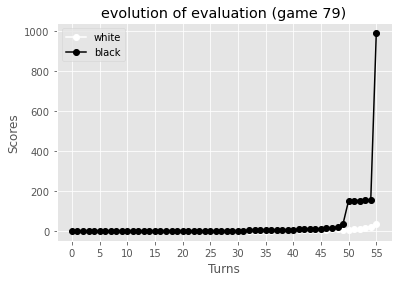

Evol_score = 0.8200000000000001
M1_score =  0.23700934579439256
M2_score =  0.7924309937205566
M3_score =  0.048779846073915084


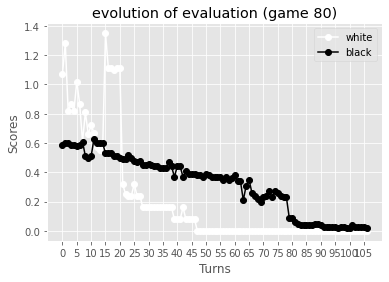

Evol_score = 0.9500000000000001
M1_score =  0.3944117647058824
M2_score =  1.2431609476656944
M3_score =  0.07885526550567301


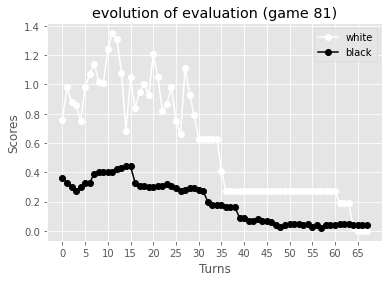

Evol_score = 0.55
M1_score =  0.113265306122449
M2_score =  0.48169204093866824
M3_score =  0.03726148114525901


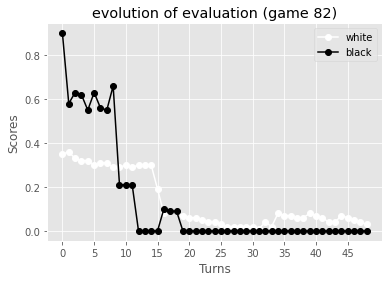

Evol_score = 0.85
M1_score =  0.5403999999999999
M2_score =  2.395052638170352
M3_score =  0.03195843012293116


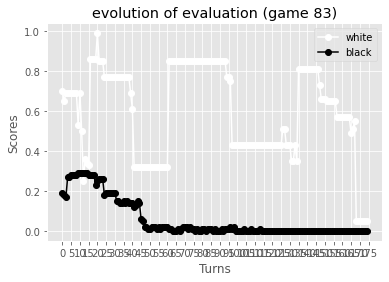

Evol_score = 0.33
M1_score =  0.19732558139534875
M2_score =  0.3429199544787269
M3_score =  0.02625311680479271


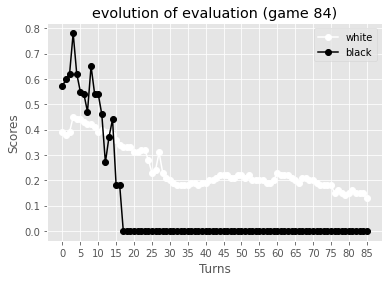

Evol_score = 6.379999999999999
M1_score =  2.4015789473684213
M2_score =  1.1000683604678898
M3_score =  0.18137328667142968


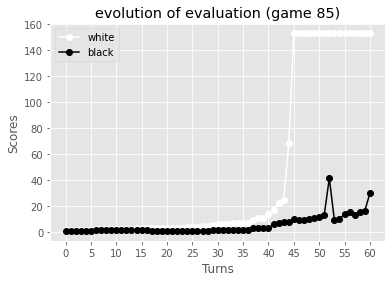

Evol_score = 1.1199999999999999
M1_score =  0.2772307692307692
M2_score =  0.34595961854837776
M3_score =  0.10943119029949094


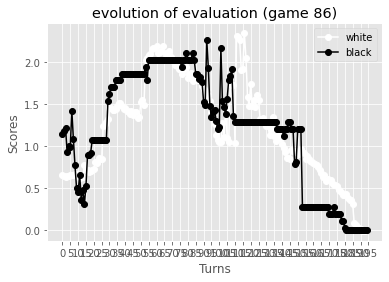

Evol_score = 2.05
M1_score =  0.8035087719298245
M2_score =  0.4452813508813276
M3_score =  0.16570750859869648


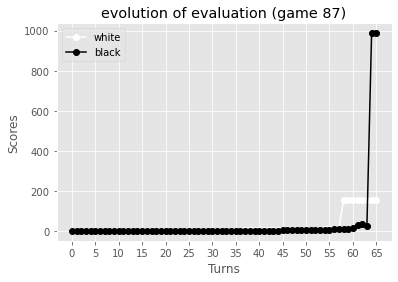

Evol_score = 0.4800000000000001
M1_score =  0.15119047619047624
M2_score =  0.28714717561125086
M3_score =  0.048610879595882756


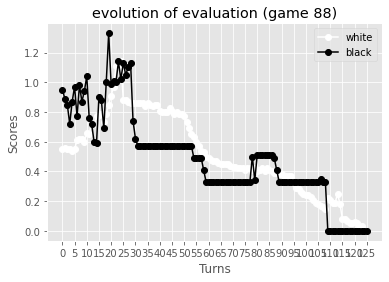

Evol_score = 4.94
M1_score =  2.0837254901960782
M2_score =  0.9244618720958158
M3_score =  0.15725345197786833


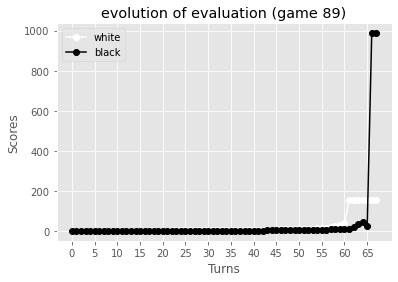

Evol_score = 0.8800000000000001
M1_score =  0.23804347826086958
M2_score =  0.9664425239698402
M3_score =  0.06843780780980142


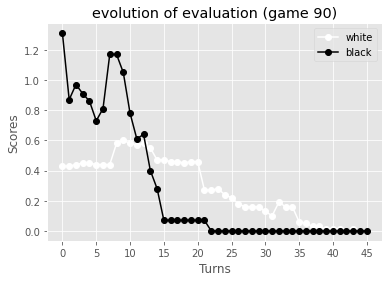

Evol_score = 3.26
M1_score =  1.032258064516129
M2_score =  0.5115530664168407
M3_score =  0.35688579635819656


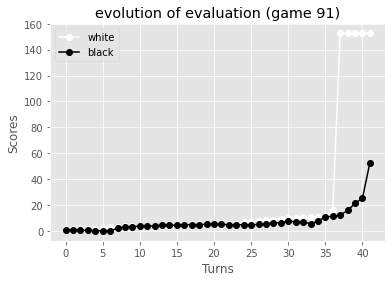

Evol_score = 2.8399999999999994
M1_score =  1.0002702702702702
M2_score =  0.38735563805111284
M3_score =  0.3047032262828792


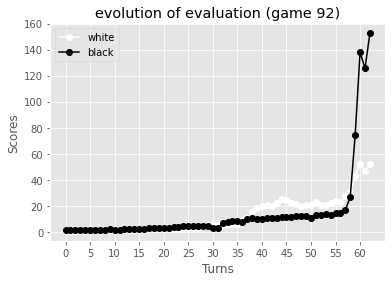

Evol_score = 1.0299999999999998
M1_score =  0.21809523809523806
M2_score =  1.3109504153957912
M3_score =  0.05322161407028314


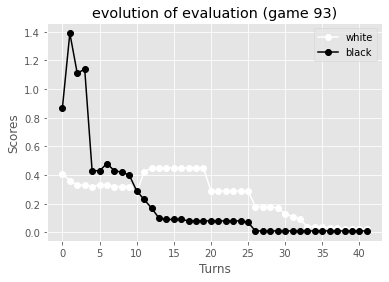

Evol_score = 0.61
M1_score =  0.134375
M2_score =  0.32854606889267096
M3_score =  0.045746136648404295


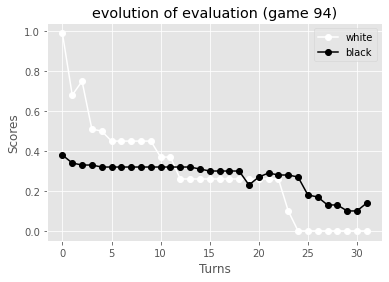

Evol_score = 0.7400000000000001
M1_score =  0.47546666666666665
M2_score =  1.7636161870346814
M3_score =  0.047130531801610864


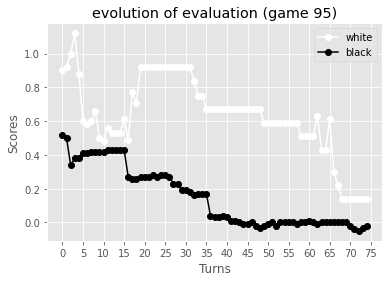

Evol_score = 2.579999999999999
M1_score =  0.6895945945945946
M2_score =  0.26509515682901497
M3_score =  0.25891053803689695


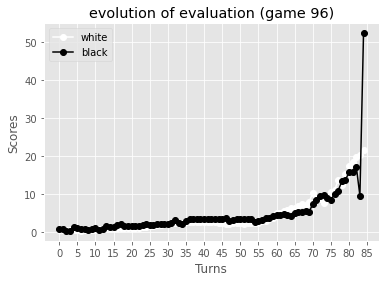

Evol_score = 5.2700000000000005
M1_score =  2.683584905660377
M2_score =  1.1114991673464139
M3_score =  0.20572531356717122


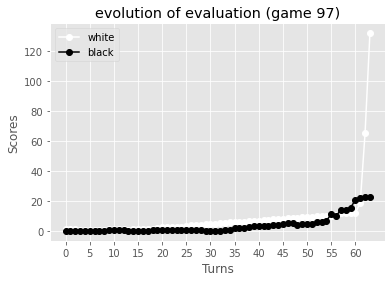

Evol_score = 0.7300000000000001
M1_score =  0.28569892473118286
M2_score =  0.433972844727243
M3_score =  0.04851245759699586


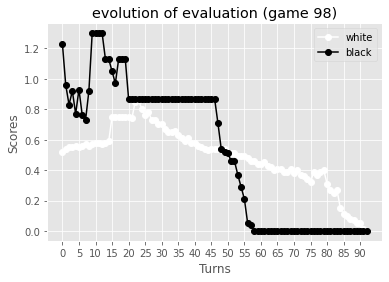

Evol_score = 4.3
M1_score =  1.0797435897435896
M2_score =  1.1208230673412156
M3_score =  0.15531558057625655


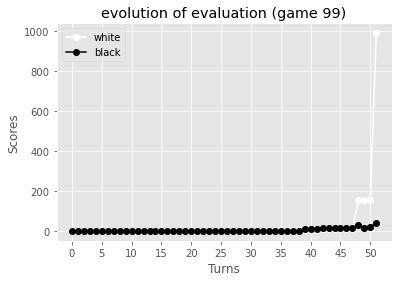

Evol_score = 2.619999999999999
M1_score =  0.8007894736842105
M2_score =  0.40383707899701654
M3_score =  0.25315177095754515


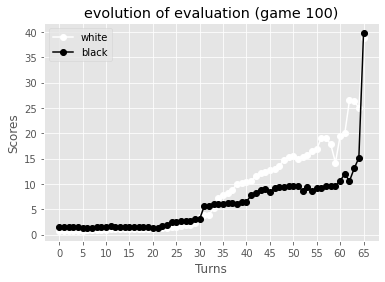

In [33]:
# http://talkchess.com/forum3/viewtopic.php?t=74375
'''
d      depth
sd     selective depth
pd     predicted move (ponder)
mt     move time
tl     time left
s      speed
n      nodes
pv     predicted variation
tb     tablebase hits
h      ?
ph     ponder hit ratio (in percentage)
wv     evaluation in pawns from white POV (white value)
R50    remaining moves before application of the 50-move-draw-rule
Rd     ?
Rr     ?
mb     material balance (P-p N-n B-b R-r Q-q)
'''


CHECK_MATE_VALUE=1000.0
def process_game(g):
    ground = g.headers.get("Round")
    w_wvs = []
    b_wvs = []
    white_turn=True
    completely_finished=False # M35 or M38 ... I guess mate is unavoidable 
    for node in g.mainline():
        if completely_finished:
            break
        metadata = node.comment
        if "book" in metadata:
            continue
        # print(metadata)
        # TODO: parse metadata (it's a string)
        for data in metadata.split(","):
            # key=value
            kv = data.split("=")
            if len(kv) > 1:
                k = kv[0].strip()
                v = kv[1].strip()
                # print(k, v)
                if (k == 'wv'):
                    try:
                        fv = float(v)
                    except ValueError:
                        # print("Mate?", v)
                        fv = CHECK_MATE_VALUE
                        completely_finished=True
                        break
                    if (white_turn):
                        w_wvs.append(fv)
                    else:
                        b_wvs.append(fv)
        white_turn= not white_turn
    return w_wvs, b_wvs

# https://tcec-chess.com/#div=sf&game=61&season=20
# https://tcec-chess.com/#div=sf&game=59&season=20
# https://tcec-chess.com/#div=sf&game=49&season=20  

# https://twitter.com/gmmds/status/1356024271886278657
# https://tcec-chess.com/#div=sf&game=97&season=20

pgn = open(pgnfile)
count_game = 0
while True:
    count_game+=1
    game = chess.pgn.read_game(pgn)
    if game is None:
        break
    w_wvs, b_wvs = process_game(game)
    # filter high values, threshold == 10
    w_filtered = [x for x, y in zip(w_wvs, b_wvs) if abs(x) < 10 and abs(y) < 10]
    b_filtered = [y for x, y in zip(w_wvs, b_wvs) if abs(x) < 10 and abs(y) < 10]
    evol = [abs(x - y) for x, y in zip(w_wvs, b_wvs) if x < 10 and y < 10]
    print("Evol_score =", max(evol))    
    print("M1_score = ", m1(w_filtered, b_filtered))
    print("M2_score = ", m2(w_filtered, b_filtered))
    print("M3_score = ", m3v(w_filtered, b_filtered,1))
    plt.figure()
    plt.title("evolution of evaluation (game " + str(count_game) + ")")
    plot_game(w_wvs, b_wvs)

    
    